In [411]:
import os
import pandas as pd
import csv
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import PIL
import h5py
import math
import scipy
from scipy import ndimage
from tensorflow.python.framework import ops
from numpy import zeros, newaxis


In [412]:
import tensorflow as tf
print ("TensorFlow version: " + tf.__version__)

TensorFlow version: 1.13.1


In [413]:
home = os.path.expanduser("~")
dataRoot = os.path.join(home, "CS230", "CheXpert-v1.0-small")
os.listdir(dataRoot)

['valid', 'valid.csv', '.DS_Store', 'train', 'train.csv']

In [414]:
# Train dataframe preprocessing
train_df = pd.read_csv(os.path.join(dataRoot, "train.csv"), encoding = "ISO-8859-1")
print(train_df.columns)

Index([u'Path', u'Sex', u'Age', u'Frontal/Lateral', u'AP/PA', u'No Finding',
       u'Enlarged Cardiomediastinum', u'Cardiomegaly', u'Lung Opacity',
       u'Lung Lesion', u'Edema', u'Consolidation', u'Pneumonia',
       u'Atelectasis', u'Pneumothorax', u'Pleural Effusion', u'Pleural Other',
       u'Fracture', u'Support Devices'],
      dtype='object')


In [415]:
# Filtering for Frontal imaging
sub_train = train_df[train_df["Frontal/Lateral"] == "Frontal"]
# Drop AP/PA
sub_train = sub_train.drop(["AP/PA"], axis = 1)
# Convert Unmenttioned to Negatives  i.e. Nah to 0
sub_train = sub_train.fillna(0)
# Convert Uncertain to Positive i.e. -1 to 1
sub_train = sub_train.replace(-1, 1)



In [416]:
# Pull cols to form y_train
cols_train = ["No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"] #...
Y_train = sub_train[cols_train]
print("the shape of the Y_train set before transpose is:",Y_train.shape)
#Y_train = np.transpose(Y_train)
# Using 1/10th of the data for basline model
Y_train = Y_train[:sub_train.shape[0]/100]
#Y_train = np.transpose(Y_train)
#print(y_train)
print("The shape of the Y_train set after transpose and reduction is:", Y_train.shape)
print("The number of training examples is:",Y_train.shape[1])



('the shape of the Y_train set before transpose is:', (191027, 14))
('The shape of the Y_train set after transpose and reduction is:', (1910, 14))
('The number of training examples is:', 14)


In [417]:
print(sub_train.shape[0])

191027


In [318]:
# # Forming x_train

# from glob import glob
# from os.path import join
# image_path_list = []
# for patient_folder in glob(join("/Users/rishabhsirdesai/CS230/CheXpert-v1.0-small/train/", "*")):
#     #print(patient_folder)
#     for study in glob(join(patient_folder, "study*")):
#         #print(study)
#         #break
#         for image in glob(join(study, "*frontal.jpg")):
#             image_path_list.append(image)
#             #break
    
       
# print(len(image_path_list))
    




In [418]:
from tqdm import tqdm #to track progress


# importing images from the path mentioned in the.csv file and converting them into numpy arrays
def load_data(img_rows = 224,img_cols = 224): 
    X_train = []   
     
    for image in tqdm(sub_train["Path"][:sub_train.shape[0]/100]):   
        
        img = Image.open("/Users/rishabhsirdesai/CS230/" + image)         
        img.load()         
        img = img.resize((img_rows, img_cols), PIL.Image.ANTIALIAS)         
        data = np.asarray(img, dtype="float64")         
        X_train.append(data)         
    
    return np.array(X_train)
    
X_train = load_data()

100%|██████████| 1910/1910 [00:13<00:00, 143.98it/s]


In [419]:
print(len(X_train)) #verifying the match between y_train and x_train

1910


In [420]:
print(X_train.shape)

(1910, 224, 224)


In [421]:
#converint each image in X to a consolidated tensor
tensor_X_train = [tf.convert_to_tensor(image_data, np.float32) for image_data in X_train]

In [422]:
for image_tensor in tensor_X:
    print(image_tensor)
    break

Tensor("Const_38382:0", shape=(224, 224), dtype=float32)


In [424]:
len(tensor_X)

19102

In [425]:
sub_train.head()

,Path,Sex,Age,Frontal/Lateral,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/train/patient00001/study1/...,Female,68,Frontal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
1,CheXpert-v1.0-small/train/patient00002/study2/...,Female,87,Frontal,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,1.0,0.0
2,CheXpert-v1.0-small/train/patient00002/study1/...,Female,83,Frontal,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4,CheXpert-v1.0-small/train/patient00003/study1/...,Male,41,Frontal,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CheXpert-v1.0-small/train/patient00004/study1/...,Female,20,Frontal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [426]:
# Valid data preprocessing

valid_df = pd.read_csv(os.path.join(dataRoot, "valid.csv"), encoding = "ISO-8859-1")
print(valid_df.columns)


Index([u'Path', u'Sex', u'Age', u'Frontal/Lateral', u'AP/PA', u'No Finding',
       u'Enlarged Cardiomediastinum', u'Cardiomegaly', u'Lung Opacity',
       u'Lung Lesion', u'Edema', u'Consolidation', u'Pneumonia',
       u'Atelectasis', u'Pneumothorax', u'Pleural Effusion', u'Pleural Other',
       u'Fracture', u'Support Devices'],
      dtype='object')


In [427]:
# Filtering for Frontal imaging
sub_valid = valid_df[valid_df["Frontal/Lateral"] == "Frontal"]
# Drop AP/PA
sub_valid = sub_valid.drop(["AP/PA"], axis = 1)
# Convert Unmenttioned to Negatives  i.e. Nah to 0
sub_valid = sub_valid.fillna(0)
# Convert Uncertain to Positive i.e. -1 to 1
sub_valid = sub_valid.replace(-1, 1)

In [428]:
# Pull cols to form y_valid
cols_valid = ["No Finding","Enlarged Cardiomediastinum","Cardiomegaly","Lung Opacity","Lung Lesion","Edema","Consolidation","Pneumonia","Atelectasis","Pneumothorax","Pleural Effusion","Pleural Other","Fracture","Support Devices"] #...
Y_test = sub_valid[cols_valid]
print("the shape of the y_valid set before transpose is:",
      Y_test.shape)
#Y_test = np.transpose(Y_test)
# Using 1/10th of the data for basline model
Y_test = Y_test[:sub_valid.shape[0]]
#print(y_train)
print("The shape of the Y_valid set is:", Y_test.shape)
print("The number of valid examples is:",Y_test.shape[1])

('the shape of the y_valid set before transpose is:', (202, 14))
('The shape of the Y_valid set is:', (202, 14))
('The number of valid examples is:', 14)


In [429]:
from tqdm import tqdm #to track progress


# importing images from the path mentioned in the.csv file and converting them into numpy arrays
def load_data_valid(img_rows = 224,img_cols = 224): 
    X_test = []   
     
    for image_valid in tqdm(sub_valid["Path"][:sub_valid.shape[0]]):   
        
        img_valid = Image.open("/Users/rishabhsirdesai/CS230/" + image_valid)         
        img_valid.load()         
        img_valid = img_valid.resize((img_rows, img_cols), PIL.Image.ANTIALIAS)         
        data_valid = np.asarray(img_valid, dtype="float64")         
        X_test.append(data_valid)         
    
    return np.array(X_valid)
    
X_test = load_data_valid()


100%|██████████| 202/202 [00:01<00:00, 121.41it/s]


In [430]:
print(len(X_test))

202


In [431]:
print(X_test.shape)

(202, 224, 224)


In [432]:
#converint each image in X to a consolidated tensor
tensor_X_test = [tf.convert_to_tensor(image_data, np.float32) for image_data in X_test]

In [433]:
print(len(tensor_X_test))

202


In [434]:
sub_valid.head()

,Path,Sex,Age,Frontal/Lateral,No Finding,Enlarged Cardiomediastinum,Cardiomegaly,Lung Opacity,Lung Lesion,Edema,Consolidation,Pneumonia,Atelectasis,Pneumothorax,Pleural Effusion,Pleural Other,Fracture,Support Devices
0,CheXpert-v1.0-small/valid/patient64541/study1/...,Male,73,Frontal,0.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,CheXpert-v1.0-small/valid/patient64542/study1/...,Male,70,Frontal,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
3,CheXpert-v1.0-small/valid/patient64543/study1/...,Male,85,Frontal,0.0,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,CheXpert-v1.0-small/valid/patient64544/study1/...,Female,42,Frontal,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,CheXpert-v1.0-small/valid/patient64545/study1/...,Female,55,Frontal,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


y = [[ 7.  7.  7. ... 11. 11. 11.]
 [ 0.  0.  0. ...  0.  0.  0.]
 [32. 13. 29. ... 21. 26. 35.]
 ...
 [28. 28. 28. ...  4.  4.  5.]
 [13. 10.  8. ... 10. 11. 11.]
 [ 6.  6.  5. ... 28. 26. 25.]]


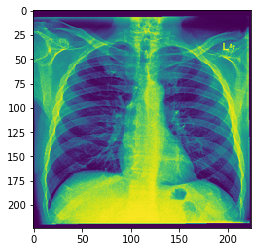

In [435]:

# Example of a picture
index = 1
plt.imshow(X_test[index])
print ("y = " + str(np.squeeze(X_test[:, index])))

In [445]:
# X_train = X_train_orig/255.
# X_test = X_test_orig/255.
# Y_train = convert_to_one_hot(Y_train_orig, 6).T
# Y_test = convert_to_one_hot(Y_test_orig, 6).T
X_train = np.reshape(X_train , (1910,224,224,1))
X_test = np.reshape(X_test , (202,224,224,1))
print ("number of training examples = " + str(X_train.shape[0]))
print ("number of test examples = " + str(X_test.shape[0]))
print ("X_train shape: " + str(X_train.shape))
print ("Y_train shape: " + str(Y_train.shape))
print ("X_test shape: " + str(X_test.shape))
print ("Y_test shape: " + str(Y_test.shape))
conv_layers = {}

number of training examples = 1910
number of test examples = 202
X_train shape: (1910, 224, 224, 1)
Y_train shape: (1910, 14)
X_test shape: (202, 224, 224, 1)
Y_test shape: (202, 14)


In [446]:
Y_test = np.array(Y_test)
Y_train = np.array(Y_train)


In [447]:
# Building the Model

In [448]:
# Create Placeholders

def create_placeholders(n_H0, n_W0, n_C0, n_y):
    """
    Creates the placeholders for the tensorflow session.
    
    Arguments:
    n_H0 -- scalar, height of an input image
    n_W0 -- scalar, width of an input image
    n_C0 -- scalar, number of channels of the input
    n_y -- scalar, number of classes
        
    Returns:
    X -- placeholder for the data input, of shape [None, n_H0, n_W0, n_C0] and dtype "float"
    Y -- placeholder for the input labels, of shape [None, n_y] and dtype "float"
    """

    X = tf.placeholder(tf.float32, shape=(None, n_H0, n_W0, n_C0), name='X')
    Y = tf.placeholder(tf.float32, shape=(None, n_y), name='Y') 
    
    return X, Y

In [449]:
X, Y = create_placeholders(224, 224, 1, 14)
print ("X = " + str(X))
print ("Y = " + str(Y))

X = Tensor("X:0", shape=(?, 224, 224, 1), dtype=float32)
Y = Tensor("Y:0", shape=(?, 14), dtype=float32)


In [450]:
# Initilize Parameters

In [451]:
def initialize_parameters():
    tf.set_random_seed(1)                   

    W1 = tf.get_variable("W1", shape = (4,4,1,8), initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    W2 = tf.get_variable("W2", shape = (2,2,8,16), initializer = tf.contrib.layers.xavier_initializer(seed = 0))
    parameters = {"W1": W1,
                  "W2": W2}
    
    return parameters

In [453]:
#Forward Prop


In [484]:

def forward_propagation(X, parameters):
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    W2 = parameters['W2']
    
    # CONV2D: stride of 1, padding 'SAME'
    Z1 = tf.nn.conv2d(X, W1, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A1 = tf.nn.relu(Z1)
    # MAXPOOL: window 8x8, sride 8, padding 'SAME'
    P1 = tf.nn.max_pool(A1, ksize=[1, 8, 8, 1], strides=[1, 8, 8, 1], padding='SAME')
    # CONV2D: filters W2, stride 1, padding 'SAME'
    Z2 = tf.nn.conv2d(P1, W2, strides=[1, 1, 1, 1], padding='SAME')
    # RELU
    A2 = tf.nn.relu(Z2)
    # MAXPOOL: window 4x4, stride 4, padding 'SAME'
    P2 = tf.nn.max_pool(A2, ksize=[1, 4, 4, 1], strides=[1, 4, 4, 1], padding='SAME')
    # FLATTEN
    P2 = tf.contrib.layers.flatten(P2)
    # FULLY-CONNECTED without non-linear activation function (not not call softmax).
    # 6 neurons in output layer. Hint: one of the arguments should be "activation_fn=None" 
    Z3 = tf.contrib.layers.fully_connected(P2, 14, activation_fn=tf.nn.sigmoid)
    return Z3

In [485]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(224, 224, 1, 14)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(Z3, {X: np.random.randn(2,224,224,1), Y: np.random.randn(2,14)})
    print("Z3 = " + str(a))

Z3 = [[0.13331395 0.3292729  0.02207786 0.46242708 0.38039407 0.91147065
  0.6036091  0.38164413 0.2448237  0.65223134 0.31336176 0.7779126
  0.2712241  0.1931957 ]
 [0.16013971 0.33575034 0.02703723 0.49077454 0.43726438 0.9173784
  0.66054696 0.3676662  0.26324236 0.6583149  0.31874067 0.8055221
  0.31248695 0.18074109]]


In [486]:
# Compute Cost

In [487]:

def compute_cost(Z3, Y):
    cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits=Z3, labels=Y))

    return cost

In [488]:
tf.reset_default_graph()

with tf.Session() as sess:
    np.random.seed(1)
    X, Y = create_placeholders(224,224, 1, 14)
    parameters = initialize_parameters()
    Z3 = forward_propagation(X, parameters)
    cost = compute_cost(Z3, Y)
    init = tf.global_variables_initializer()
    sess.run(init)
    a = sess.run(cost, {X: np.random.randn(4,224,224,1), Y: np.random.randn(4,14)})
    print("cost = " + str(a))

cost = -1.6556602


In [489]:
def random_mini_batches(X, Y, mini_batch_size = 64, seed = 0):

    
    m = X.shape[0]                  # number of training examples
    mini_batches = []
    np.random.seed(seed)
    
    # Step 1: Shuffle (X, Y)
    permutation = list(np.random.permutation(m))
    shuffled_X = X[permutation,:,:,:]
    shuffled_Y = Y[permutation,:]

    # Step 2: Partition (shuffled_X, shuffled_Y). Minus the end case.
    num_complete_minibatches = int(math.floor(m/mini_batch_size)) # number of mini batches of size mini_batch_size in your partitionning
    for k in range(0, num_complete_minibatches):
        mini_batch_X = shuffled_X[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:,:,:]
        mini_batch_Y = shuffled_Y[k * mini_batch_size : k * mini_batch_size + mini_batch_size,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    # Handling the end case (last mini-batch < mini_batch_size)
    if m % mini_batch_size != 0:
        mini_batch_X = shuffled_X[num_complete_minibatches * mini_batch_size : m,:,:,:]
        mini_batch_Y = shuffled_Y[num_complete_minibatches * mini_batch_size : m,:]
        mini_batch = (mini_batch_X, mini_batch_Y)
        mini_batches.append(mini_batch)
    
    return mini_batches

In [492]:
# GRADED FUNCTION: model

def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.009,
          num_epochs = 100, minibatch_size = 64, print_cost = True):
    
    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep results consistent (tensorflow seed)
    seed = 3                                          # to keep results consistent (numpy seed)
    (m, n_H0, n_W0, n_C0) = X_train.shape
    n_y = Y_train.shape[1]                            
    costs = []                                        # To keep track of the cost
    
    # Create Placeholders of the correct shape
    X, Y = create_placeholders(n_H0, n_W0, n_C0, n_y)

    # Initialize parameters
    parameters = initialize_parameters()
    
    # Forward propagation: Build the forward propagation in the tensorflow graph
    Z3 = forward_propagation(X, parameters)
    
    # Cost function: Add cost function to tensorflow graph
    cost = compute_cost(Z3, Y)
    
    # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer that minimizes the cost.
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(cost)
    
    # Initialize all the variables globally
    init = tf.global_variables_initializer()
     
    # Start the session to compute the tensorflow graph
    with tf.Session() as sess:
        
        # Run the initialization
        sess.run(init)
        
        # Do the training loop
        for epoch in range(num_epochs):

            minibatch_cost = 0.
            num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
            seed = seed + 1
            minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)

            for minibatch in minibatches:

                # Select a minibatch
                (minibatch_X, minibatch_Y) = minibatch
                _ , temp_cost = sess.run([optimizer, cost], {X: minibatch_X, Y: minibatch_Y})
                
                minibatch_cost += temp_cost / num_minibatches
                

            # Print the cost every epoch
            if print_cost == True and epoch % 5 == 0:
                print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
            if print_cost == True and epoch % 1 == 0:
                costs.append(minibatch_cost)
        
        
        # plot the cost
        plt.plot(np.squeeze(costs))
        plt.ylabel('cost')
        plt.xlabel('iterations (per tens)')
        plt.title("Learning rate =" + str(learning_rate))
        plt.show()

        # Calculate the correct predictions
        predict_op = tf.argmax(Z3, 1)
        correct_prediction = tf.equal(predict_op, tf.argmax(Y, 1))
        
        # Calculate accuracy on the test set
        accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
        print(accuracy)
        train_accuracy = accuracy.eval({X: X_train, Y: Y_train})
        test_accuracy = accuracy.eval({X: X_test, Y: Y_test})
        print("Train Accuracy:", train_accuracy)
        print("Test Accuracy:", test_accuracy)
                
        return train_accuracy, test_accuracy, parameters

Cost after epoch 0: 7.959586
Cost after epoch 5: 7.944057
Cost after epoch 10: 7.950032
Cost after epoch 15: 7.951460
Cost after epoch 20: 7.950036
Cost after epoch 25: 7.948217
Cost after epoch 30: 7.944165
Cost after epoch 35: 7.942039
Cost after epoch 40: 7.947614
Cost after epoch 45: 7.943263
Cost after epoch 50: 7.948206
Cost after epoch 55: 7.946095
Cost after epoch 60: 7.946601
Cost after epoch 65: 7.948010
Cost after epoch 70: 7.943858
Cost after epoch 75: 7.947407
Cost after epoch 80: 7.948919
Cost after epoch 85: 7.947614
Cost after epoch 90: 7.949433
Cost after epoch 95: 7.948010


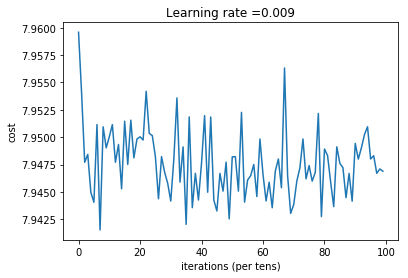

Tensor("Mean_1:0", shape=(), dtype=float32)
('Train Accuracy:', 0.3471204)
('Test Accuracy:', 0.18811882)


In [493]:
_, _, parameters = model(X_train, Y_train, X_test, Y_test)